<a href="https://colab.research.google.com/github/heerboi/AI-from-scratch/blob/main/building_(tiny)_language_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# a very simple language model (using frequencies)

In [1]:
!curl https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt > names.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   543k      0 --:--:-- --:--:-- --:--:--  544k


In [29]:
words = open("names.txt", 'r').read().splitlines()

for word in words[:4]:
	chars = ['.'] + list(word) + ['.']

	for char1, char2 in zip(chars, chars[1:]):
		print(char1, char2)

. e
e m
m m
m a
a .
. o
o l
l i
i v
v i
i a
a .
. a
a v
v a
a .
. i
i s
s a
a b
b e
e l
l l
l a
a .


In [32]:
import torch

# Tracking counts
frequencies = torch.zeros((27, 27), dtype = torch.int32)
unique_chars = ['.'] + sorted(list(set(''.join(words))))

stoi = {c:i for i, c in enumerate(unique_chars)}


itos = {i:c for c, i in stoi.items()}

for word in words:
	chars = ['.'] + list(word) + ['.']

	for char1, char2 in zip(chars, chars[1:]):
		char1_idx = stoi[char1]
		char2_idx = stoi[char2]
		frequencies[char1_idx, char2_idx] += 1

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

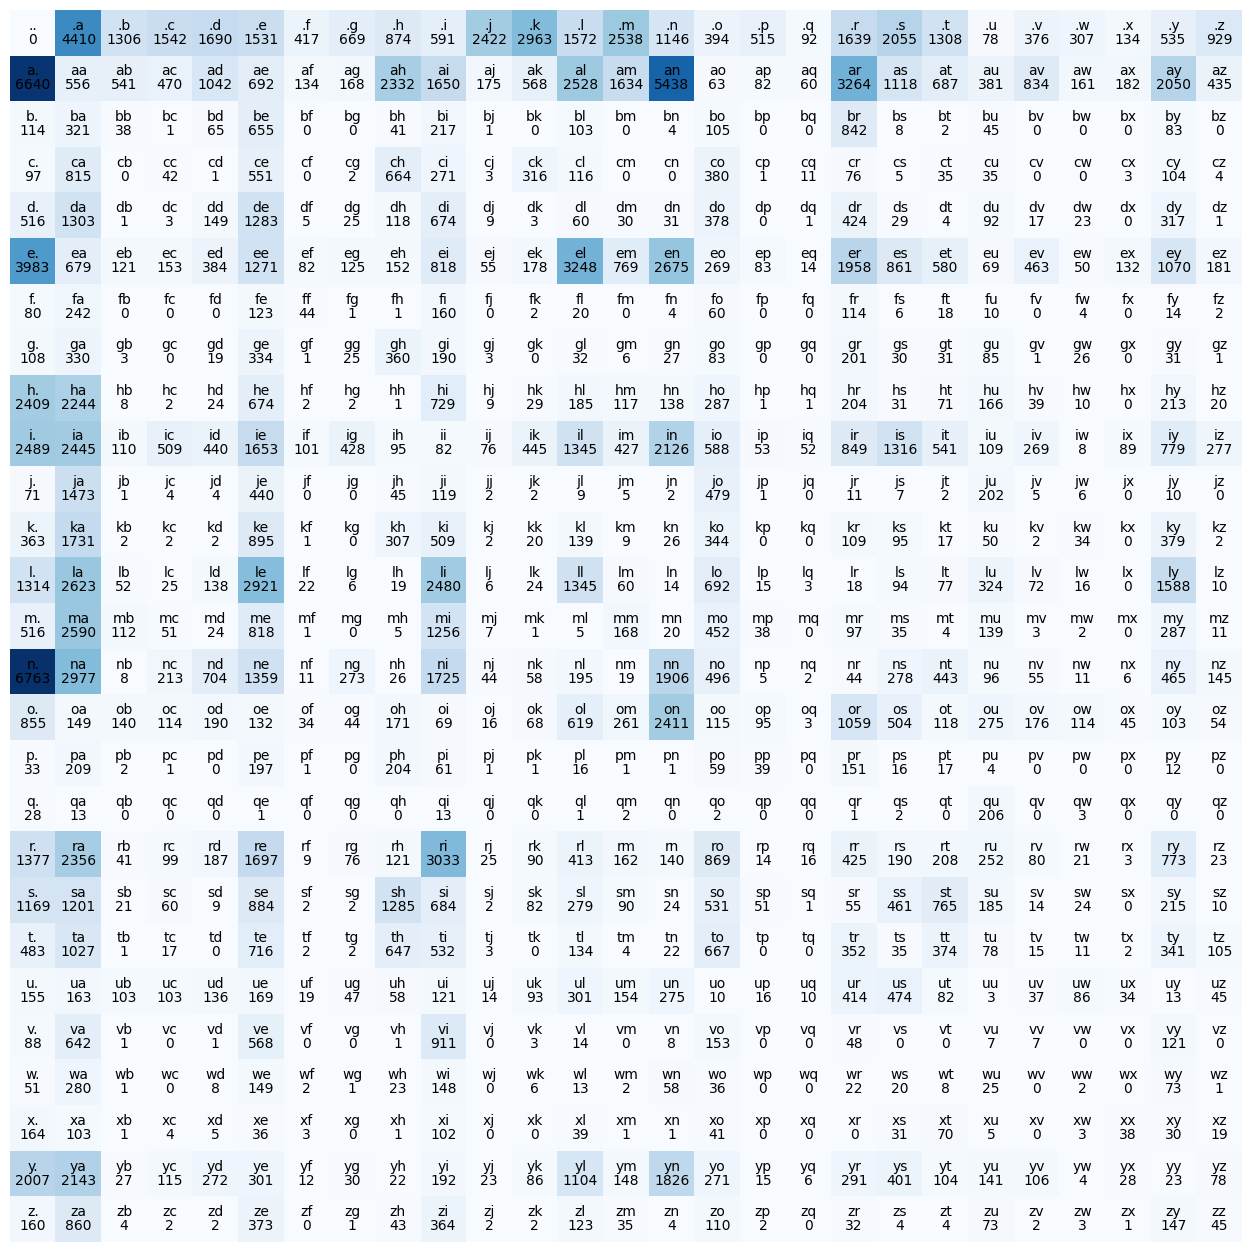

In [33]:
# Graphing
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (16,16))
plt.imshow(frequencies, cmap="Blues")

for idx1 in range(27):
	for idx2 in range(27):
		pair = itos[idx1] + itos[idx2]
		plt.text(idx2, idx1, pair, ha = "center", va="bottom", color = "black")
		plt.text(idx2, idx1, frequencies[idx1, idx2].item(), ha="center", va="top", color="black")

plt.axis("off")

In [34]:
# Calculate probabilities
probabilities = (frequencies+1).float()
probabilities /= probabilities.sum(dim=1, keepdim=True)

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

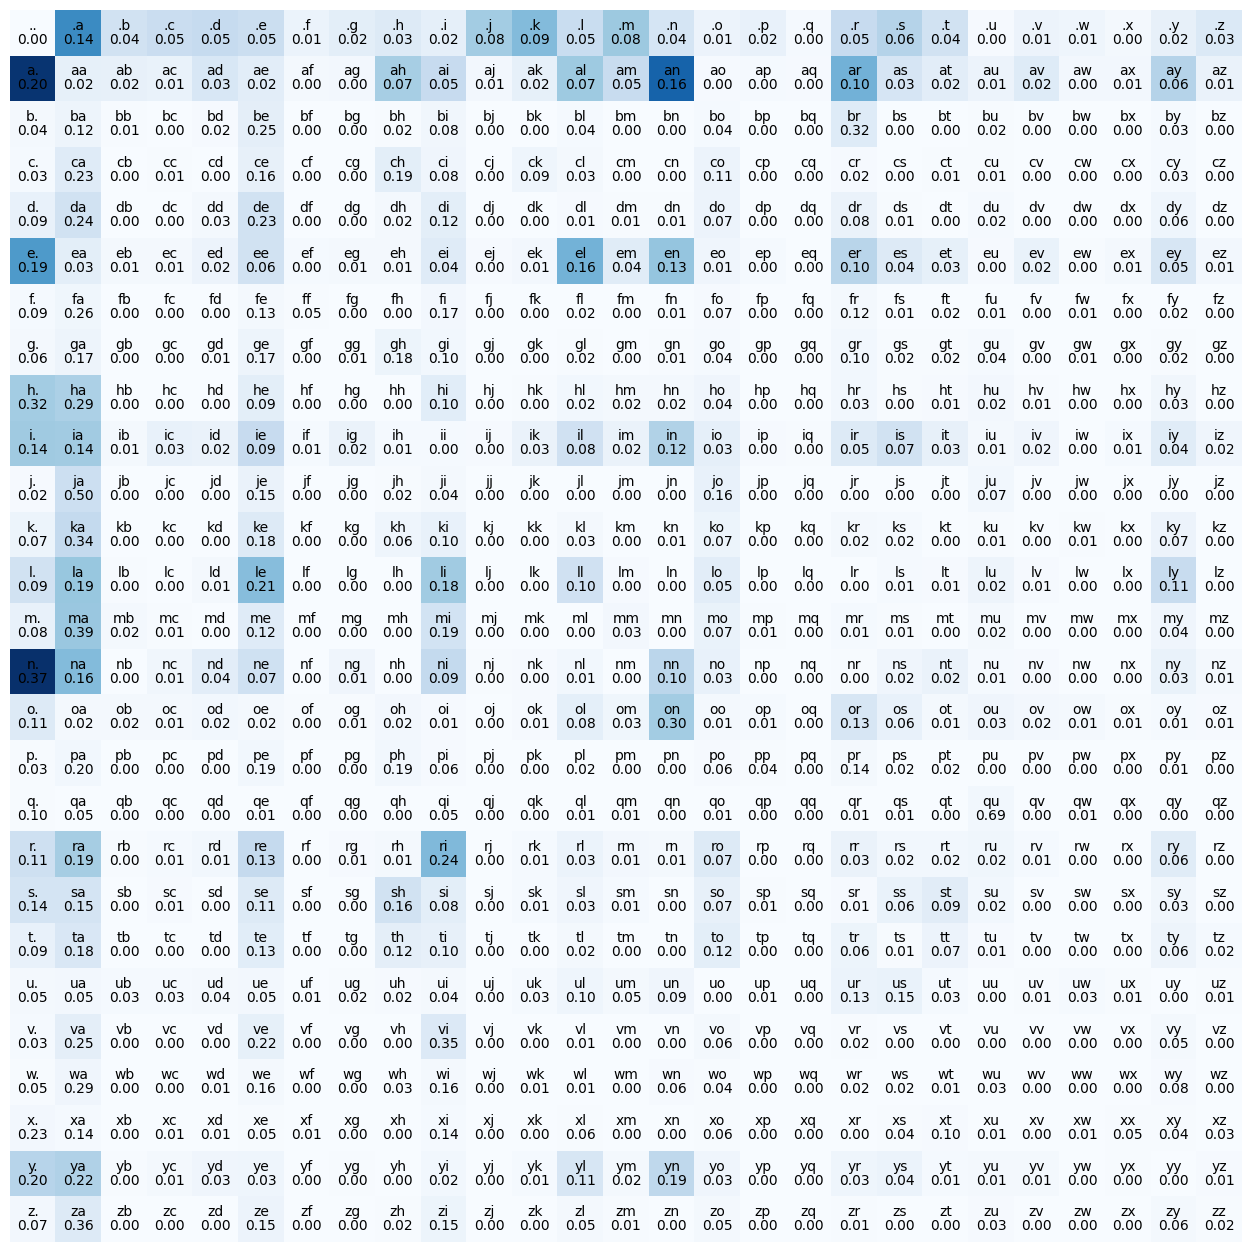

In [35]:
# Graphing
plt.figure(figsize = (16,16))
plt.imshow(frequencies, cmap="Blues")

for idx1 in range(27):
	for idx2 in range(27):
		pair = itos[idx1] + itos[idx2]
		plt.text(idx2, idx1, pair, ha = "center", va="bottom", color = "black")
		plt.text(idx2, idx1, format(probabilities[idx1, idx2].item(), ".2f"), ha="center", va="top", color="black")

plt.axis("off")

In [42]:
for _ in range(5):
	name = []
	ix = 0
	while True:
		probability = probabilities[ix]
		ix = torch.multinomial(probability, num_samples=1, replacement=True).item()
		if ix == 0:
			break
		name.append(itos[ix])

	print("".join(name))

jure
nerke
ade
kannitan
tyn


In [47]:
likelihood = 1.0
for word in words[:3]:
	chars = ['.'] + list(word) + ['.']
	for char1, char2 in zip(chars, chars[1:]):
                # iterate through all examples and fetch the probability of char2 given char1
		pair_prob = probabilities[stoi[char1], stoi[char2]]
		likelihood *= pair_prob

print(f"Model likelihood: {likelihood}")

Model likelihood: 1.3984727371766537e-17


In [49]:
log_likelihood = 0
n = 0
for word in words:
	chars = ['.'] + list(word) + ['.']
	for char1, char2 in zip(chars, chars[1:]):
		pair_prob = probabilities[stoi[char1], stoi[char2]]
		log_likelihood += torch.log(pair_prob)
		n += 1

print(f"Model log likelihood: {log_likelihood/n:.4f}")
print(f"Model negative log likelihood: {-log_likelihood/n:.4f}")

Model log likelihood: -2.4544
Model negative log likelihood: 2.4544


# why do we need a non-linearity!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

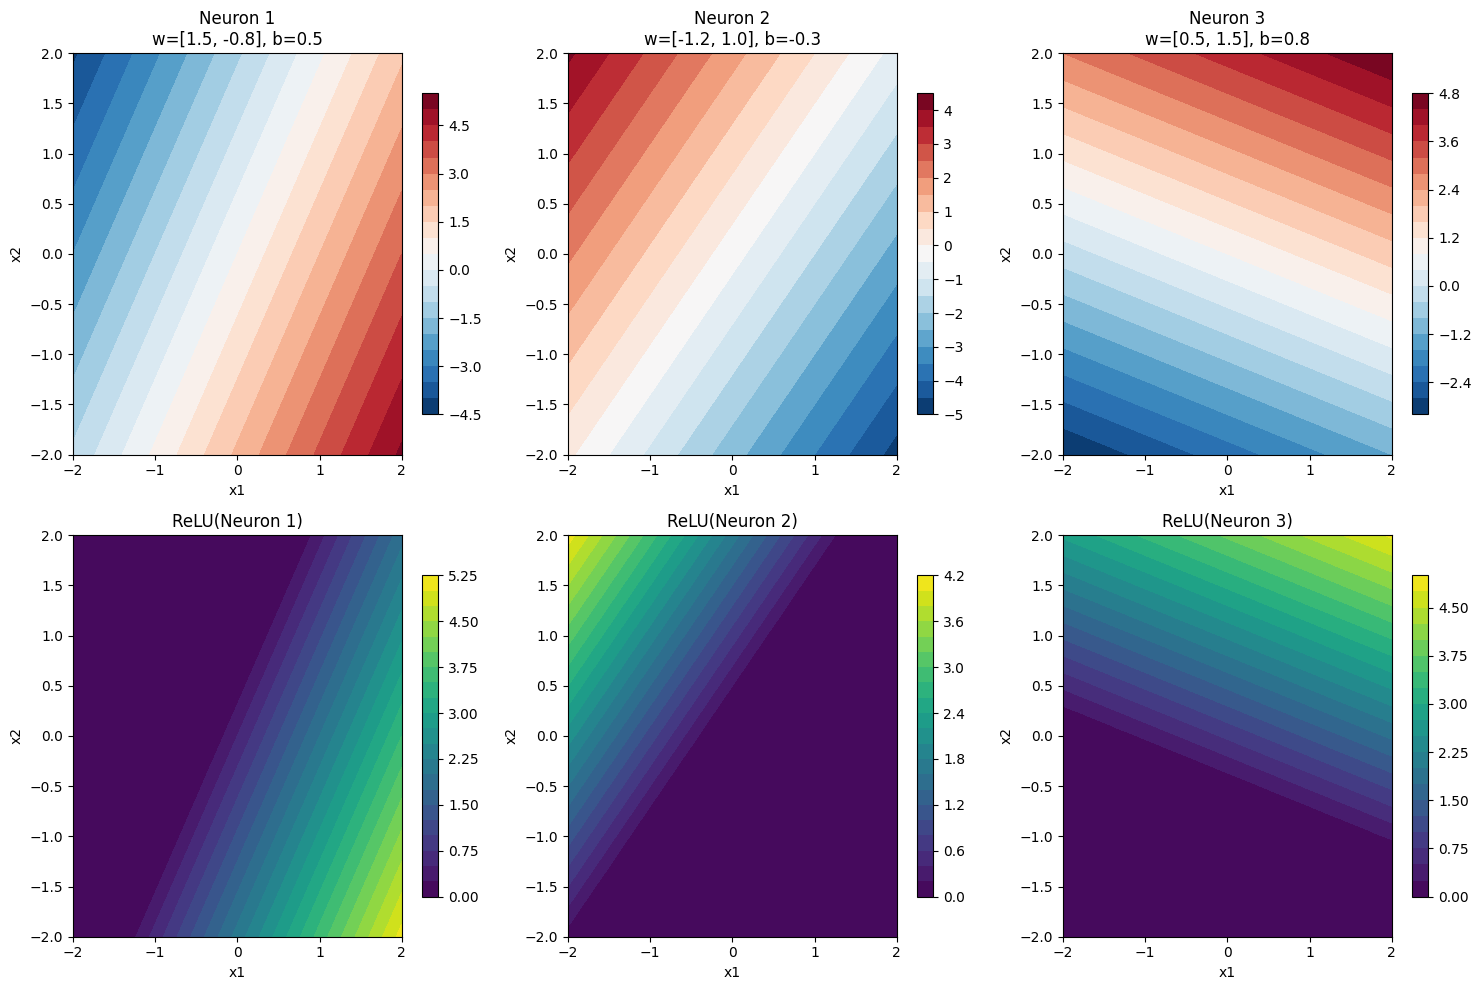

In [ ]:
x1 = np.linspace(-2, 2, 20)
x2 = np.linspace(-2, 2, 20)
X1, X2 = np.meshgrid(x1, x2)
X = np.column_stack([X1.ravel(), X2.ravel()])

# x1   x2
# -2   -2
# -1.8 -2
# -2   -1.8
# and so on

# w1 = w1x1
#      w1x2
# and so on...
w1 = np.array([[1.5], [-0.8]])   # positive x1, negative x2
w2 = np.array([[-1.2], [1.0]])   # Negative x1, positive x2
w3 = np.array([[0.5], [1.5]])    # Positive both, stronger x2
b1, b2, b3 = 0.5, -0.3, 0.8


# (400, 2) @ (2, 1) = (400, 1) + (,1) = (400,1)
# i.e. multiplying w1x1 * x1, w1x2 * x2 and adding
# and so on...
y1 = X @ w1 + b1
y2 = X @ w2 + b2
y3 = X @ w3 + b3

act1 = relu(y1)
act2 = relu(y2)
act3 = relu(y3)
activations = act1 + act2 + act3
linear_output = y1 + y2 + y3

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
linear_2d = linear_output.reshape(X1.shape)
nonlinear_2d = activations.reshape(X1.shape)

# Plot individual neuron outputs (before ReLU)
for i, (y, w, b, title) in enumerate(zip([y1, y2, y3], [w1, w2, w3], [b1, b2, b3], ['Neuron 1', 'Neuron 2', 'Neuron 3'])):
    y_2d = y.reshape(X1.shape)
    im = axes[0, i].contourf(X1, X2, y_2d, levels=20, cmap='RdBu_r')
    axes[0, i].set_title(f'{title}\nw=[{w[0,0]:.1f}, {w[1,0]:.1f}], b={b:.1f}')
    axes[0, i].set_xlabel('x1')
    axes[0, i].set_ylabel('x2')
    plt.colorbar(im, ax=axes[0, i], shrink=0.8)

relu_outputs = [relu(y1), relu(y2), relu(y3)]
for i, (y, title) in enumerate(zip(relu_outputs, ['ReLU(Neuron 1)', 'ReLU(Neuron 2)', 'ReLU(Neuron 3)'])):
    y_2d = y.reshape(X1.shape)
    im = axes[1, i].contourf(X1, X2, y_2d, levels=20, cmap='viridis')
    axes[1, i].set_title(title)
    axes[1, i].set_xlabel('x1')
    axes[1, i].set_ylabel('x2')
    plt.colorbar(im, ax=axes[1, i], shrink=0.8)

plt.tight_layout()
plt.show()
fig.savefig('nn_outputs.png', dpi=300)


In [ ]:
X[:5]

array([[-2.        , -2.        ],
       [-1.78947368, -2.        ],
       [-1.57894737, -2.        ],
       [-1.36842105, -2.        ],
       [-1.15789474, -2.        ]])

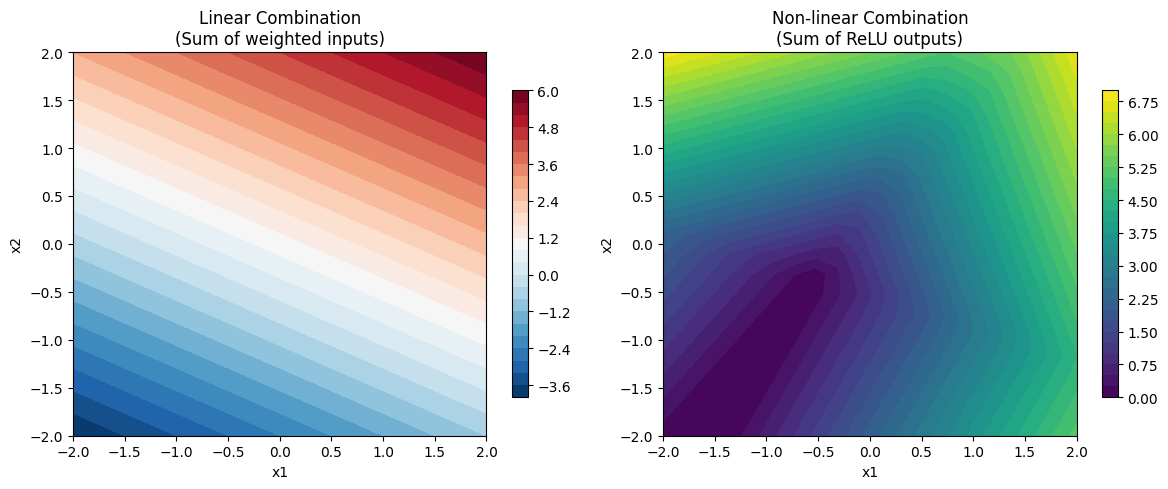

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
im1 = ax1.contourf(X1, X2, linear_2d, levels=30, cmap='RdBu_r')
ax1.set_title('Linear Combination\n(Sum of weighted inputs)')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
plt.colorbar(im1, ax=ax1, shrink=0.8)

# Non-linear combination
im2 = ax2.contourf(X1, X2, nonlinear_2d, levels=30, cmap='viridis')
ax2.set_title('Non-linear Combination\n(Sum of ReLU outputs)')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
plt.colorbar(im2, ax=ax2, shrink=0.8)

plt.tight_layout()
plt.show()
fig.savefig('non-linear_vs_linear.png', dpi=300)

# neural net approach

In [ ]:
!curl https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt > names.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   499k      0 --:--:-- --:--:-- --:--:--  499k


In [ ]:
words = open("names.txt", "r").read().splitlines()

In [ ]:
unique_chars = ["."] + sorted(list(set("".join(words))))
stoi = {s:i for i, s in enumerate(unique_chars)}
itos = {i:s for s, i in stoi.items()}

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
block_size = 2
hidden_size = 50
embedding_size = 3
token_size = 27
lr = 1e-2

In [ ]:
xs = []
ys = []
for word in words:
    word = word + "."

    context = [0] * block_size

    for char in word:
        xs.append(context)
        ys.append(stoi[char])
        context = context[1:] + [stoi[char]]

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [ ]:
split = int(len(xs) * 0.8)
X_train, y_train = xs[:split], ys[:split]
X_test, y_test = xs[split:], ys[split:]

In [ ]:
xs[:5], ys[:5]

(tensor([[ 0,  0],
         [ 0,  5],
         [ 5, 13],
         [13, 13],
         [13,  1]]),
 tensor([ 5, 13, 13,  1,  0]))

In [ ]:
len(xs)

228146

In [ ]:
len(X_train), len(X_test)

(182516, 45630)

In [ ]:
torch.flatten(torch.randn(10, 2, 10)).shape

torch.Size([200])

In [ ]:
embedding = nn.Embedding(num_embeddings=token_size, embedding_dim=embedding_size)
W1 = torch.randn((block_size * embedding_size, hidden_size)) * 0.01
b1 = torch.randn(hidden_size)
W2 = torch.randn((hidden_size, token_size)) * 0.01
b2 = torch.randn(token_size)

parameters = [embedding.weight, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters)

1808

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
iterations = 200000
batch_size = 1024

for iter in range(iterations):

    # select a random set of indices of size batch_size
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    # dims = (batch, 2)
    batch = X_train[ix]

    # dims = (batch, 2, 3)
    embeddings = embedding(batch)

    # dims = (batch, 6)
    # flatten flattens the inputs to a single dim
    X_train_embeds = nn.Flatten()(embeddings)

    W1x = torch.relu(X_train_embeds @ W1 + b1)
    W2W1x = W1x @ W2 + b2
    # Below is the explicit softmax + loss
    # but this does not handle exploding gradients due to bad initialisation
    # so we use cross entropy (softmax + -ve log likelihood)

    # probabilities = F.softmax(W2W1x, dim=1)
    # loss = -probabilities[torch.arange(batch_size), y_train[ix]].log().mean()
    loss = F.cross_entropy(W2W1x, y_train[ix])

    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data -= lr * p.grad

    if iter % 10000 == 0:
        print(f"{iter} | Loss: {loss.item()}")

0 | Loss: 3.9692740440368652
10000 | Loss: 2.559088945388794
20000 | Loss: 2.4944424629211426
30000 | Loss: 2.4443776607513428
40000 | Loss: 2.4495723247528076
50000 | Loss: 2.3885910511016846
60000 | Loss: 2.408491849899292
70000 | Loss: 2.4016146659851074
80000 | Loss: 2.377897262573242
90000 | Loss: 2.3793208599090576
100000 | Loss: 2.366854667663574
110000 | Loss: 2.382587194442749
120000 | Loss: 2.3372790813446045
130000 | Loss: 2.3454439640045166
140000 | Loss: 2.3287222385406494
150000 | Loss: 2.3283684253692627
160000 | Loss: 2.2693276405334473
170000 | Loss: 2.2926831245422363
180000 | Loss: 2.384345293045044
190000 | Loss: 2.3405165672302246


In [ ]:
with torch.no_grad():
    X_test_embeds = nn.Flatten()(embedding(X_test))
    W1x_test = torch.relu(X_test_embeds @ W1 + b1)
    W2W1x_test = W1x_test @ W2 + b2
    test_probs = F.softmax(W2W1x_test, dim=1)
    test_loss = -test_probs[torch.arange(len(X_test)), y_test].log().mean()
print("Test loss: ", test_loss.item())

Test loss:  2.5320544242858887


In [ ]:
names = []
for _ in range(5):
    context = [0] * block_size
    name = ""
    while True:
        with torch.no_grad():
            input_embeds = embedding(torch.tensor(context)).view(1, -1)
            W1x = torch.relu(input_embeds @ W1 + b1)
            W2W1x = W1x @ W2 + b2
            probs = F.softmax(W2W1x, dim=1)

            next_char = torch.multinomial(probs, num_samples=1, replacement=True).item()
            if next_char == 0:
                break
            context = context[1:] + [next_char]
            name += itos[next_char]

    print(name)

ardendeziylan
katha
kreenn
yrm
arilyn


In [ ]:
nn.Flatten()(input_embeds)

tensor([[-0.5101, -0.8104, -0.7530,  0.9436, -0.0028,  2.0692]])